<a href="https://colab.research.google.com/github/raianeti/Projeto-PIBIC-JR-2020/blob/main/Solutions_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Projeto PIBIC JR


1.   Aplicando uma abordagem de Machine Learning baseada no melhor KNN para detecção de ataques Botnet em IoT

Neste trabalho propõe-se desenvolver um mecanismo para a detecção de ataques botnet em redes IoT, que aplique uma abordagem de Machine Learning baseada em KNN, de forma a selecionar o melhor valor do parâmetro *k* para o problema. Com a finalidade de prover maior nível de segurança para os dispositivos IoT e suas aplicações, bem como possibilitar avanços das pesquisas de sistemas de detecção de intrusões (*Intrusion detection System* - IDS)

In [35]:
#montando o drive

from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
#Importando bibliotecas
import pandas as pd
import numpy as np
from sklearn_pandas import DataFrameMapper
from sklearn.metrics import accuracy_score
from sklearn.datasets.samples_generator import make_blobs 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.datasets import make_classification
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import precision_score
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import warnings
import time
warnings.filterwarnings(action='ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [37]:
# importando os datasets
normalData=pd.read_csv('/content/drive/My Drive/PibicFinal/mirai/benign_traffic.csv')
attackData=pd.read_csv('/content/drive/My Drive/PibicFinal/mirai/ack.csv')
print(normalData.keys()) #vizualizando o nome das colunas

Index(['MI_dir_L5_weight', 'MI_dir_L5_mean', 'MI_dir_L5_variance',
       'MI_dir_L3_weight', 'MI_dir_L3_mean', 'MI_dir_L3_variance',
       'MI_dir_L1_weight', 'MI_dir_L1_mean', 'MI_dir_L1_variance',
       'MI_dir_L0.1_weight',
       ...
       'HpHp_L0.1_radius', 'HpHp_L0.1_covariance', 'HpHp_L0.1_pcc',
       'HpHp_L0.01_weight', 'HpHp_L0.01_mean', 'HpHp_L0.01_std',
       'HpHp_L0.01_magnitude', 'HpHp_L0.01_radius', 'HpHp_L0.01_covariance',
       'HpHp_L0.01_pcc'],
      dtype='object', length=115)


In [38]:
#print(attackData.head(6))
print(attackData.shape) #shape dos dados
print(normalData.shape)

(113285, 115)
(13113, 115)


In [39]:
#classificação binária dos dados para verificar número de pacotes
attackData['Class']= 1
normalData['Class']= 0
#print(dados, dados["Classe"])


In [40]:
#combinando os dados nomral com attaques
dados=pd.concat([normalData,attackData],axis=0)
dados.shape


(126398, 116)

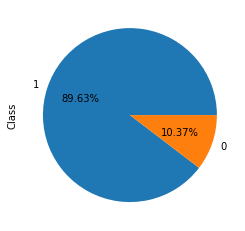

In [41]:

#plotando gráfico com quantidade de pacotes para cada dataset
%matplotlib inline  
import matplotlib.pyplot as plt
dados['Class'].value_counts().plot(kind='pie', autopct='%.2f%%');
#plt.title("Quantidade de pacotes por dataset")

#plt.savefig('imagens/quantidade_pacotes_classeACK.eps', format='eps')

Output=dados['Class']
#Output=np.array(Output).flatten() 
#print(Output)

#print(dados, dados["Classe"])
#excluindo classes desnecessárias do dataset. De 115features, agora apenas 23
dados=dados.drop(["MI_dir_L5_weight", "MI_dir_L3_weight", "MI_dir_L0.1_weight", "MI_dir_L0.01_weight",
                 "MI_dir_L5_mean", "MI_dir_L3_mean", "MI_dir_L0.1_mean", "MI_dir_L0.01_mean", "MI_dir_L5_variance",
                 "MI_dir_L3_variance", "MI_dir_L0.1_variance", "MI_dir_L0.01_variance", "H_L5_weight","H_L3_weight",
                  "H_L0.1_weight", "H_L0.01_weight","H_L5_mean","H_L3_mean", "H_L0.1_mean", "H_L0.01_mean", 
                 "H_L5_variance", "H_L3_variance", "H_L0.1_variance", "H_L0.01_variance", "HH_L5_weight", "HH_L3_weight",
                  "HH_L0.1_weight", "HH_L0.01_weight","HH_L5_mean","HH_L3_mean",
                 "HH_L0.1_mean", "HH_L0.01_mean", "HH_L5_std", "HH_L3_std", "HH_L0.1_std", "HH_L0.01_std",
                 "HH_L5_magnitude", "HH_L3_magnitude", "HH_L0.1_magnitude", "HH_L0.01_magnitude", "HH_L5_radius", 
                  "HH_L3_radius", "HH_L0.1_radius", "HH_L0.01_radius", "HH_L5_covariance","HH_L3_covariance", 
                  "HH_L0.1_covariance", "HH_L0.01_covariance","HH_L5_pcc", "HH_L3_pcc", "HH_L5_pcc","HH_L0.1_pcc",
                 "HH_L0.01_pcc", "HH_jit_L5_weight", "HH_jit_L3_weight", "HH_jit_L0.1_weight", "HH_jit_L0.01_weight",
                 "HH_jit_L5_mean", "HH_jit_L3_mean", "HH_jit_L0.1_mean", "HH_jit_L0.01_mean", "HH_jit_L5_variance",
                 "HH_jit_L3_variance", "HH_jit_L0.1_variance", "HH_jit_L0.01_variance", "HpHp_L5_weight","HpHp_L3_weight",
                 "HpHp_L0.1_weight", "HpHp_L0.01_weight", "HpHp_L5_mean", "HpHp_L3_mean", "HpHp_L0.1_mean",
                 "HpHp_L0.01_mean", "HpHp_L5_std", "HpHp_L3_std", "HpHp_L0.1_std", "HpHp_L0.01_std", "HpHp_L5_magnitude",
                 "HpHp_L3_magnitude", "HpHp_L0.1_magnitude", "HpHp_L0.01_magnitude", "HpHp_L5_radius", "HpHp_L3_radius",
                 "HpHp_L0.1_radius", "HpHp_L0.01_radius", "HpHp_L5_covariance", "HpHp_L3_covariance", "HpHp_L5_covariance",
                  "HpHp_L0.1_covariance","HpHp_L0.01_covariance", "HpHp_L5_pcc", "HpHp_L3_pcc", "HpHp_L0.1_pcc", 
                  "HpHp_L0.01_pcc"],axis=1)

In [28]:
#renomeando as features
dados = (dados.rename(columns={"H_L1_weight":"IP_Ori_weight",
                               "H_L1_mean":"IP_Ori_mean",                                
                               "H_L1_variance":"IP_Ori_variance",
                               "HH_L1_weight":"Traf_Ori_Des_weight",
                               "HH_L1_mean":"Traf_Ori_Des_mean",
                               "HH_L1_std":"Traf_Ori_Des_std",
                               "HH_L1_magnitude":"Traf_Ori_Des_magnitude",
                               "HH_L1_radius":"Traf_Ori_Des_radius",
                               "HH_L1_covariance":"Traf_Ori_Des_covariance",
                               "HH_L1_pcc":"Traf_Ori_Des_pcc",
                               "HH_jit_L1_weight":"Insta_Ori_Des_weight",
                               "HH_jit_L1_mean":"Insta_Ori_Des_mean",
                               "HH_jit_L1_variance":"Insta_Ori_Des_variance",
                               "HpHp_L1_weight":"Insta_Ori_Des_weight",
                               "HpHp_L1_mean":"Insta_Ori_Des_mean",
                               "HpHp_L1_std":"Insta_Ori_Des_std",
                               "HpHp_L1_magnitude":"Insta_Ori_Des_magnitude",
                               "HpHp_L1_radius":"Insta_Ori_Des_radius",
                               "HpHp_L1_covariance":"Insta_Ori_Des_covariance",
                               "HpHp_L1_pcc":"Insta_Ori_Des_pcc"}))
print(dados.index)



Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            113275, 113276, 113277, 113278, 113279, 113280, 113281, 113282,
            113283, 113284],
           dtype='int64', length=126398)


In [42]:
#Exibir as colunas e os tipos de dados de cada coluna - dataset original
tipos_de_dados = pd.DataFrame(dados.dtypes, columns=['Tipo de Dados'])
tipos_de_dados.columns.name='Característica'
tipos_de_dados

Característica,Tipo de Dados
MI_dir_L1_weight,float64
MI_dir_L1_mean,float64
MI_dir_L1_variance,float64
H_L1_weight,float64
H_L1_mean,float64
H_L1_variance,float64
HH_L1_weight,float64
HH_L1_mean,float64
HH_L1_std,float64
HH_L1_magnitude,float64


In [43]:
#Reorganizando as instancias de forma aleatória
sampler=np.random.permutation(len(dados))
dados=dados.take(sampler)
dados.head()

,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,H_L1_weight,H_L1_mean,H_L1_variance,HH_L1_weight,HH_L1_mean,HH_L1_std,HH_L1_magnitude,HH_L1_radius,HH_L1_covariance,HH_L1_pcc,HH_jit_L1_weight,HH_jit_L1_mean,HH_jit_L1_variance,HpHp_L1_weight,HpHp_L1_mean,HpHp_L1_std,HpHp_L1_magnitude,HpHp_L1_radius,HpHp_L1_covariance,HpHp_L1_pcc,Class
86220,657.298514,477.540963,36935.239992,657.298514,477.540963,36935.239992,542.389376,565.999979,0.103743,565.999979,0.010763,0.000000,0.000000,542.389376,0.002674,0.000033,1.000000,566.000000,0.000000,566.00000,0.00000,0.000000,0.000000,1
10949,1.520434,152.388259,19662.982010,1.520434,152.388259,19662.982010,1.520434,152.388259,140.224755,1008.697690,39161.625580,-760.306313,-0.029463,1.520434,4.606340,169.786024,1.520434,152.388259,140.224755,1008.69769,39161.62558,-760.306313,-0.029463,0
55830,578.741457,434.844221,49132.174768,578.741457,434.844221,49132.174768,428.662460,565.996367,1.355742,565.996367,1.838035,0.000000,0.000000,428.662460,0.003388,0.000053,1.000000,566.000000,0.000000,566.00000,0.00000,0.000000,0.000000,1
55766,568.077291,445.985348,46289.484791,568.077291,445.985348,46289.484791,433.263804,565.996060,1.411967,565.996060,1.993650,0.000000,0.000000,433.263804,0.003353,0.000057,1.000000,566.000000,0.000000,566.00000,0.00000,0.000000,0.000000,1
88613,692.630667,452.424210,44569.888804,692.630667,452.424210,44569.888804,537.164113,565.999999,0.017890,565.999999,0.000320,0.000000,0.000000,537.164113,0.002702,0.000039,1.000000,566.000000,0.000000,566.00000,0.00000,0.000000,0.000000,1


In [44]:
dados.sample(5)

,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,H_L1_weight,H_L1_mean,H_L1_variance,HH_L1_weight,HH_L1_mean,HH_L1_std,HH_L1_magnitude,HH_L1_radius,HH_L1_covariance,HH_L1_pcc,HH_jit_L1_weight,HH_jit_L1_mean,HH_jit_L1_variance,HpHp_L1_weight,HpHp_L1_mean,HpHp_L1_std,HpHp_L1_magnitude,HpHp_L1_radius,HpHp_L1_covariance,HpHp_L1_pcc,Class
91692,638.681489,446.766007,46007.850024,638.681489,446.766007,46007.850024,1.000000,60.000000,0.000000,60.000000,0.00000,0.000000,0.00000,1.000000,1.507659e+09,0.000000,1.000000,60.000000,0.000000,60.000000,0.00000,0.000000,0.00000,1
52580,605.135179,437.096132,48573.335551,605.135179,437.096132,48573.335551,451.764274,565.020164,22.244931,565.020164,494.83695,0.000000,0.00000,451.764274,3.220605e-03,0.000069,1.000000,566.000000,0.000000,566.000000,0.00000,0.000000,0.00000,1
99807,576.921100,420.083362,52475.456395,576.921100,420.083362,52475.456395,410.398375,565.999919,0.202089,565.999919,0.04084,0.000000,0.00000,410.398375,3.728000e-03,0.001051,1.000000,566.000000,0.000000,566.000000,0.00000,0.000000,0.00000,1
6570,1.811050,203.128321,24270.155230,1.811050,203.128321,24270.155230,1.792079,204.643434,155.909976,431.234768,24308.26956,-39.075554,-0.02196,1.792079,4.658601e+00,23.979625,1.792079,204.643434,155.909976,431.234768,24308.26956,-39.075554,-0.02196,0
75963,540.169864,467.035297,40248.946491,540.169864,467.035297,40248.946491,1.000000,60.000000,0.000000,60.000000,0.00000,0.000000,0.00000,1.000000,1.507659e+09,0.000000,1.000000,60.000000,0.000000,60.000000,0.00000,0.000000,0.00000,1


In [46]:
X = dados.loc[:, dados.columns != 'Class'].values
y = dados[['Class']].values
dados['Class'].value_counts()

1    113285
0     13113
Name: Class, dtype: int64

In [50]:
#Treino
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

raw_treino_x, raw_teste_x, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify = y, random_state=42) 
scaler = StandardScaler()
scaler.fit(raw_treino_x)
X_train = scaler.transform(raw_treino_x)
x_test = scaler.transform(raw_teste_x)

In [57]:
#MODELO DECLASSIFICAÇÃO KNN

from sklearn.neighbors import KNeighborsClassifier
inicio_knn = time.time()

error_rate = []
best_k = 0
pesos = [1,2]

for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i, p=2, metric='minkowski')
    knn.fit(X_train, y_train)
    pred = knn.predict(x_test)
    error_rate.append(np.mean(pred!=y_test))

In [58]:
mini = 100
for i in range(len(error_rate)):
    if error_rate[i] < mini:
        best_k = i
        mini = error_rate[i]

In [62]:
best_k

18

Text(0, 0.5, 'Taxa de erro')

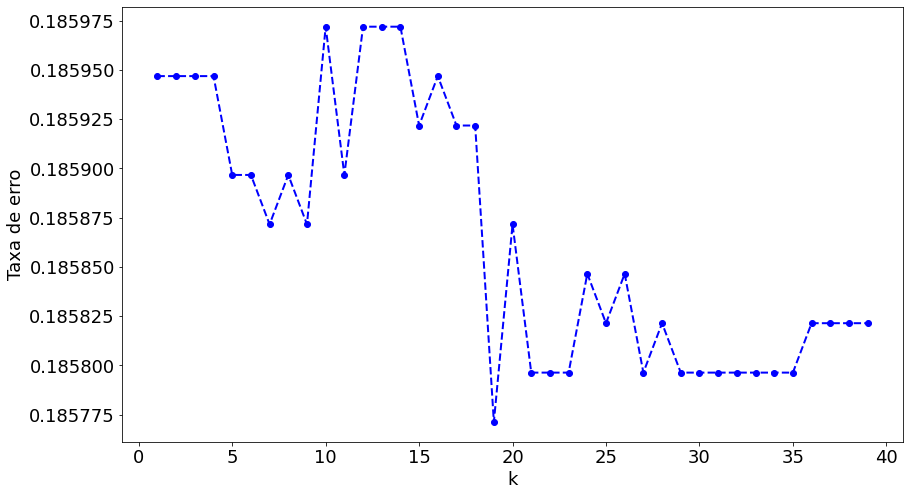

In [73]:
plt.figure(figsize=(14, 8))
plt.rcParams.update({'font.size':18})
plt.plot(range(1,40), error_rate, color='blue', linestyle='dashed', marker='o', linewidth=2.0)
plt.xlabel('k')
plt.ylabel('Taxa de erro')

In [59]:
n = 56305;
classifier_knn = KNeighborsClassifier(n_neighbors=55)

model_knn = classifier_knn.fit(x_train, y_train)
preds_knn = classifier_knn.predict(x_test)

fim_knn = time.time()
tempo_knn = fim_knn - inicio_knn
print("Tempo:", tempo_knn)

#validação cruzda
scores = cross_val_score(classifier_knn, dados, Output, cv=5, scoring='accuracy')
print("CV:", scores)
print("CV Média:", scores.mean())

#AVALIAÇÃO SVM
print("-------------------------------")
print("AVALIAÇÃO KNN")
print("-------------------------------")
accuracy_knn = accuracy_score(y_test, preds_knn)
print('Accuracy: %f' % (accuracy_knn))
#precision tp / (tp + fp)
precision_knn = precision_score(y_test, preds_knn)
print('Precision: %f' % precision_knn)
# recall: tp / (tp + fn)
recall_knn = recall_score(y_test, preds_knn)
print('Recall: %f' % recall_knn)
#f1: 2 tp / (2 tp + fp + fn)
f1_knn = f1_score(y_test, preds_knn)
print('F1 score: %f' % f1_knn)
auc_knn = roc_auc_score(y_test, preds_knn)
print('ROC AUC: %f' % auc_knn)
# confusion matrix
matrix_knn = confusion_matrix(y_test, preds_knn)
print(matrix_knn)


Tempo: 1387.6071996688843
CV: [0.89624209 0.89624209 0.89624209 0.89627754 0.89627754]
CV Média: 0.896256270214282
-------------------------------
AVALIAÇÃO KNN
-------------------------------
Accuracy: 0.999557
Precision: 0.999576
Recall: 0.999929
F1 score: 0.999753
ROC AUC: 0.998134
[[ 3266    12]
 [    2 28320]]


Confusion matrix KNN:
 [[ 3266    12]
 [    2 28320]]


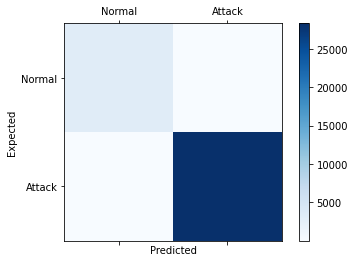

In [60]:
#matriz confusao

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.metrics.scorer import make_scorer
from sklearn.metrics import confusion_matrix

conf_mat_knn = confusion_matrix(y_true=y_test,y_pred=preds_knn)
print('Confusion matrix KNN:\n', conf_mat_knn)
labels = ['Normal', 'Attack']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat_knn, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()
#plt.savefig('imagens/Matriz_SVM_ACK.eps', format='eps')

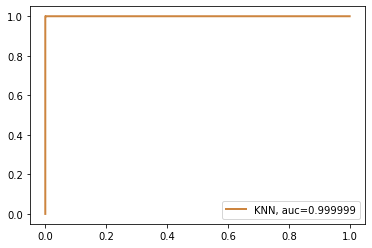

In [61]:
#curva roc

import sklearn.metrics as metrics
y_pred_proba_knn = classifier_knn.predict_proba(x_test)[::,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba_knn)
auc_knn = metrics.roc_auc_score(y_test, y_pred_proba_knn)
auc_knn = '%.6f' % auc_knn
plt.plot(fpr,tpr,label="KNN, auc="+str(auc_knn), color='peru',  linewidth=2.0)
plt.legend(loc=4)

In [66]:
#validacao

from sklearn.metrics import mean_squared_error
from math import sqrt

rmse_knn = sqrt(mean_squared_error(y_test, preds_knn))
print(rmse_knn)


0.02104846727634923
